# <center>PONTIFICIA UNIVERSIDAD CATÓLICA DEL ECUADOR</center>
### <center>Datos estructurados de Youtube</center>
### <center>CASO DE ESTUDIO: Análisis de sentimientos de la pelicula interestelar </center>


<center><img src="https://i.blogs.es/1b6bfa/nintendo-switch-2/500_333.jpeg" width="60%"></center>

## Objetivos

### Objetivo General
Realizar análisis de sentimientos usando la api de Youtube sobre el primer vistazo de la Nintendo Switch 2

### Objetivos Específicos
* Revisar el marco teórico de aprendizaje automático / IA
* Identificar numéricamente las palabras mas usadas en los comentarios del video.
* Identificar gráficamente las palabras mas usadas en los comentarios del video.


## Herramientas:
* Cuaderno Jupyter
* Python


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import googleapiclient.discovery
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.svm import SVC


In [2]:
dev = "your_key"

In [3]:
import googleapiclient.discovery

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = dev

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

request = youtube.commentThreads().list(
    part="snippet",
    videoId="itpcsQQvgAQ",
    maxResults=100,
)

comments = []

# Execute the request.
response = request.execute()

# Get the comments from the response.
for item in response['items']:
    comment = item['snippet']['topLevelComment']['snippet']
    public = item['snippet']['isPublic']
    comments.append([
        comment['authorDisplayName'],
        comment['publishedAt'],
        comment['likeCount'],
        comment['textOriginal'],
        public
    ])

while (1 == 1):
  try:
   nextPageToken = response['nextPageToken']
  except KeyError:
   break
  nextPageToken = response['nextPageToken']
  # Create a new request object with the next page token.
  nextRequest = youtube.commentThreads().list(part="snippet", videoId="itpcsQQvgAQ", maxResults=100, pageToken=nextPageToken)
  # Execute the next request.
  response = nextRequest.execute()
  # Get the comments from the next response.
  for item in response['items']:
    comment = item['snippet']['topLevelComment']['snippet']
    public = item['snippet']['isPublic']
    comments.append([
        comment['authorDisplayName'],
        comment['publishedAt'],
        comment['likeCount'],
        comment['textOriginal'],
        public
    ])

df = pd.DataFrame(comments, columns=['author', 'updated_at', 'like_count', 'text','public'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78917 entries, 0 to 78916
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      78917 non-null  object
 1   updated_at  78917 non-null  object
 2   like_count  78917 non-null  int64 
 3   text        78917 non-null  object
 4   public      78917 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 2.5+ MB


In [4]:
df.shape

(78917, 5)

In [35]:
df.to_csv("comments.csv",index=False)

In [6]:
df.head()

,author,updated_at,like_count,text,public
0,@GametronixZ,2025-01-22T01:35:35Z,0,Hope the quality format is in 4K (2160p) for T...,True
1,@kelvinkegel2304,2025-01-22T01:30:36Z,0,"Looks way better than Switch 1, now let's wait...",True
2,@phannectionsextremetierexe,2025-01-22T01:29:25Z,0,please tell me the buttons no longer wiggle an...,True
3,@bdesoto1180,2025-01-22T01:29:23Z,1,A Nintendo to know how are we going to get th...,True
4,@cjfox45,2025-01-22T01:20:00Z,0,Better have fixed that issue with the controll...,True


In [7]:
df = df[["text"]]
df.head()

,text
0,Hope the quality format is in 4K (2160p) for T...
1,"Looks way better than Switch 1, now let's wait..."
2,please tell me the buttons no longer wiggle an...
3,A Nintendo to know how are we going to get th...
4,Better have fixed that issue with the controll...


## Limpieza de los datos

In [8]:
def clean_text(texto):
    texto = re.sub(r'^RT[\s]+','', texto)
    texto = re.sub(r'https?:\/\/.*[\r\n*]','', texto)
    texto = re.sub(r'#','', texto)
    texto = re.sub(r'@[A-Za-z0-9_]+', '', texto) 
    texto = re.sub(r'http\S+|www.\S+|pic.\S+|\S+.com\S*|\S+.org\S*|\S+.net\S*', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'^\d+$', '', texto)
    texto = texto.lower().strip()
    return texto

In [9]:
df['text']

0        Hope the quality format is in 4K (2160p) for T...
1        Looks way better than Switch 1, now let's wait...
2        please tell me the buttons no longer wiggle an...
3        A Nintendo  to know how are we going to get th...
4        Better have fixed that issue with the controll...
                               ...                        
78912                                              OH CRAP
78913                                                   YO
78914                                             ITS HERE
78915                                             REAL????
78916                                                  Hey
Name: text, Length: 78917, dtype: object

In [10]:
df['clean_text'] = df['text'].apply(clean_text)

In [11]:
df

,text,clean_text
0,Hope the quality format is in 4K (2160p) for T...,hope the quality format is in 4k 2160p for tv ...
1,"Looks way better than Switch 1, now let's wait...",looks way better than switch 1 now lets wait t...
2,please tell me the buttons no longer wiggle an...,please tell me the buttons no longer wiggle an...
3,A Nintendo to know how are we going to get th...,a nintendo to know how are we going to get th...
4,Better have fixed that issue with the controll...,better have fixed that issue with the controll...
...,...,...
78912,OH CRAP,oh crap
78913,YO,yo
78914,ITS HERE,its here
78915,REAL????,real


In [12]:
df = df.reset_index(drop=True)

## Etiquetado de los datos

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [14]:
res = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['clean_text']
    polarity_score = sia.polarity_scores(text)  
    res.append(polarity_score)  

polarity_df = pd.DataFrame(res) 
df = pd.concat([df, polarity_df], axis=1) 


  0%|          | 0/78917 [00:00<?, ?it/s]

In [15]:
df

,text,clean_text,neg,neu,pos,compound
0,Hope the quality format is in 4K (2160p) for T...,hope the quality format is in 4k 2160p for tv ...,0.000,0.840,0.160,0.6908
1,"Looks way better than Switch 1, now let's wait...",looks way better than switch 1 now lets wait t...,0.124,0.760,0.116,-0.0516
2,please tell me the buttons no longer wiggle an...,please tell me the buttons no longer wiggle an...,0.081,0.824,0.095,0.2023
3,A Nintendo to know how are we going to get th...,a nintendo to know how are we going to get th...,0.000,1.000,0.000,0.0000
4,Better have fixed that issue with the controll...,better have fixed that issue with the controll...,0.000,0.734,0.266,0.4404
...,...,...,...,...,...,...
78912,OH CRAP,oh crap,0.722,0.278,0.000,-0.3818
78913,YO,yo,0.000,1.000,0.000,0.0000
78914,ITS HERE,its here,0.000,1.000,0.000,0.0000
78915,REAL????,real,0.000,1.000,0.000,0.0000


In [24]:
def applyEmotion(label):
    if label < 0:
        return "negative"
    elif label == 0:
        return "neutral"
    elif label > 0:
        return "positive"

In [25]:
df['emotion_labels'] = df['compound'].apply(applyEmotion)

In [26]:
df

,text,clean_text,neg,neu,pos,compound,emotion_labels
0,Hope the quality format is in 4K (2160p) for T...,hope the quality format is in 4k 2160p for tv ...,0.000,0.840,0.160,0.6908,positive
1,"Looks way better than Switch 1, now let's wait...",looks way better than switch 1 now lets wait t...,0.124,0.760,0.116,-0.0516,negative
2,please tell me the buttons no longer wiggle an...,please tell me the buttons no longer wiggle an...,0.081,0.824,0.095,0.2023,positive
3,A Nintendo to know how are we going to get th...,a nintendo to know how are we going to get th...,0.000,1.000,0.000,0.0000,neutral
4,Better have fixed that issue with the controll...,better have fixed that issue with the controll...,0.000,0.734,0.266,0.4404,positive
...,...,...,...,...,...,...,...
78912,OH CRAP,oh crap,0.722,0.278,0.000,-0.3818,negative
78913,YO,yo,0.000,1.000,0.000,0.0000,neutral
78914,ITS HERE,its here,0.000,1.000,0.000,0.0000,neutral
78915,REAL????,real,0.000,1.000,0.000,0.0000,neutral


In [3]:
df = pd.read_csv("comments.csv")

In [4]:
df.dropna(subset=['clean_text'], inplace=True)

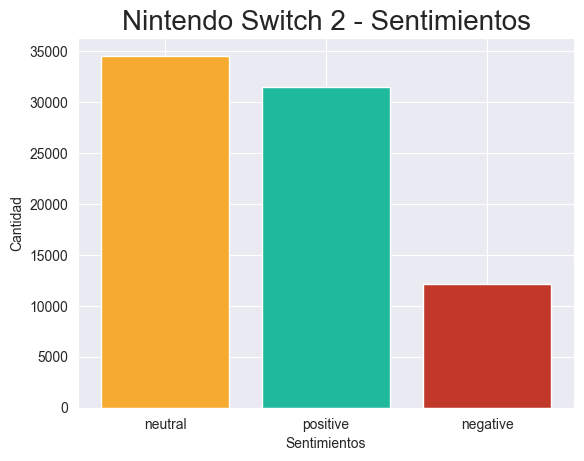

In [5]:
import matplotlib.pyplot as plt
labels = ['neutral', 'positive', 'negative']
colors = ['#f6aa30', '#1fb99e', '#c1382a']
counts = df['emotion_labels'].value_counts()

plt.bar(labels, counts, color=colors)
plt.title('Nintendo Switch 2 - Sentimientos', fontsize=20)
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad')
plt.show()

In [6]:
df['emotion_labels'].value_counts()

neutral     34533
positive    31436
negative    12141
Name: emotion_labels, dtype: int64

In [7]:
text = " ".join(df['clean_text'].astype(str))
words = text.split()  # Divide el texto en palabras

stopwords = set(STOPWORDS)
words_filter = [word for word in words if word not in stopwords]
frequency = Counter(words_filter)

In [8]:
# Generar nube de palabras
word_cloud = WordCloud(
    random_state=1,
    collocations=False,
    stopwords=STOPWORDS
).generate(text)


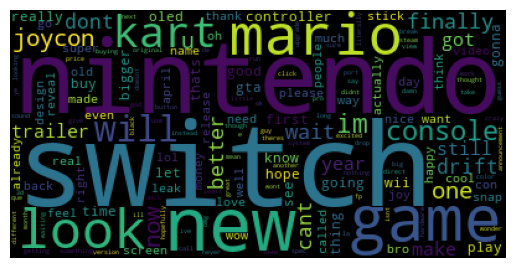

In [9]:
# Mostrar la nube generada
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [10]:
# Convertir las frecuencias a un DataFrame
df_frequency = pd.DataFrame(frequency.items(), columns=['Word', 'Frequency'])

# Ordenar las palabras por frecuencia descendente
df_frequency_sort = df_frequency.sort_values(by='Frequency', ascending=False)

In [11]:
df_frequency_sort

,Word,Frequency
21,switch,19876
56,nintendo,15407
59,2,11410
9,new,6734
11,mario,5924
...,...,...
16183,principales,1
16182,temperature,1
16180,hollyyyyyy,1
16179,ateee,1


In [11]:
# Seleccion las columnas de interés
features = df['clean_text']
labels = df['emotion_labels']

## Vectorización y Mapeo de los comentarios

### TF_IDF: Medir la relevancia de las palabras
TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento) mide la importancia de una palabra en un texto respecto a todo el conjunto de textos. Esto evita que palabras muy comunes como "el", "es" o "de" tengan demasiada influencia.



In [12]:
# Transformar texto a numeros usando TF-IDF
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(features)

### Mapeo de las etiquetas de sentimiento a valores numéricos

In [13]:
y = labels

## División del conjunto de datos en conjuntos de entrenamiento y prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Balanceo de las clases

In [15]:
# Crear instancias de RandomOverSampler y RandomUnderSampler
over_sampler = RandomOverSampler(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)

# Aplicar sobremuestreo a los datos
X_over, y_over = over_sampler.fit_resample(X_train, y_train)

# Aplicar submuestreo a los datos
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

# Verificar el balance de clases después del remuestreo
unique, counts = np.unique(y_over, return_counts=True)
print("Balance de clases después del sobremuestreo:")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_under, return_counts=True)
print("Balance de clases después del submuestreo:")
print(dict(zip(unique, counts)))

Balance de clases después del sobremuestreo:
{'negative': 27697, 'neutral': 27697, 'positive': 27697}
Balance de clases después del submuestreo:
{'negative': 9688, 'neutral': 9688, 'positive': 9688}


## Exportacion de df Balanceados

In [47]:
from sklearn.utils import resample

# Verificar el balance inicial de las clases
initial_balance = df['emotion_labels'].value_counts().to_dict()
print(f"Balance de clases inicial:\n{initial_balance}")

# Dividir el DataFrame por clases
negative = df[df['emotion_labels'] == 'negative']
neutral = df[df['emotion_labels'] == 'neutral']
positive = df[df['emotion_labels'] == 'positive']

### Sobremuestreo (Oversampling)
# Sobremuestrear todas las clases al tamaño de la clase mayoritaria
majority_size = max(len(negative), len(neutral), len(positive))

negative_oversampled = resample(negative, replace=True, n_samples=majority_size, random_state=42)
neutral_oversampled = resample(neutral, replace=True, n_samples=majority_size, random_state=42)
positive_oversampled = resample(positive, replace=True, n_samples=majority_size, random_state=42)

# Combinar las clases sobremuestreadas
df_oversampled = pd.concat([negative_oversampled, neutral_oversampled, positive_oversampled])

# Verificar el balance después del sobremuestreo
oversampled_balance = df_oversampled['emotion_labels'].value_counts().to_dict()
print(f"Balance de clases después del sobremuestreo:\n{oversampled_balance}")

### Submuestreo (Undersampling)
# Submuestrear todas las clases al tamaño de la clase minoritaria
minority_size = min(len(negative), len(neutral), len(positive))

negative_undersampled = resample(negative, replace=False, n_samples=minority_size, random_state=42)
neutral_undersampled = resample(neutral, replace=False, n_samples=minority_size, random_state=42)
positive_undersampled = resample(positive, replace=False, n_samples=minority_size, random_state=42)

# Combinar las clases submuestreadas
df_undersampled = pd.concat([negative_undersampled, neutral_undersampled, positive_undersampled])

# Verificar el balance después del submuestreo
undersampled_balance = df_undersampled['emotion_labels'].value_counts().to_dict()
print(f"Balance de clases después del submuestreo:\n{undersampled_balance}")

### Exportar datasets a CSV
df_oversampled.to_csv("oversampled_data.csv", index=False)
df_undersampled.to_csv("undersampled_data.csv", index=False)

print("Archivos exportados: 'oversampled_data.csv' y 'undersampled_data.csv'")

Balance de clases inicial:
{'neutral': 34533, 'positive': 31436, 'negative': 12141}
Balance de clases después del sobremuestreo:
{'negative': 34533, 'neutral': 34533, 'positive': 34533}
Balance de clases después del submuestreo:
{'negative': 12141, 'neutral': 12141, 'positive': 12141}
Archivos exportados: 'oversampled_data.csv' y 'undersampled_data.csv'


In [48]:
df_oversampled.to_csv("oversampled_data.csv", index=False)
df_undersampled.to_csv("undersampled_data.csv", index=False)

## Modelamiento

### DecisionTreeClassifier

#### Datos Normales

In [34]:
# Crear instancia del modelo
model = DecisionTreeClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_train, y_train, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud de cada fold: [0.85349656 0.85597696 0.85101616 0.84684324 0.86412739]
Exactitud promedio: 0.8542920622600889


In [35]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

Accuracy Test

In [36]:
y_pred = model.predict(X_test)

In [37]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with criterion gini index: 0.8619


Accuracy Train

In [39]:
y_pred_train = model.predict(X_train)

In [40]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score with criterion gini index: 1.0000


Check for overfitting and underfitting

In [41]:
print('Training set score: {:.4f}'.format(model.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.8619


Matriz de Confusion

In [42]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1532  328  593]
 [ 167 6489  180]
 [ 478  411 5444]]


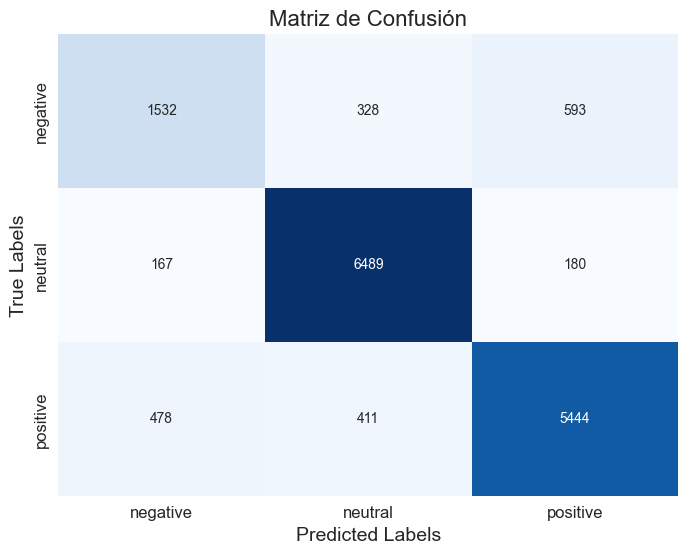

In [43]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de Clasificacion

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.70      0.62      0.66      2453
     neutral       0.90      0.95      0.92      6836
    positive       0.88      0.86      0.87      6333

    accuracy                           0.86     15622
   macro avg       0.83      0.81      0.82     15622
weighted avg       0.86      0.86      0.86     15622



#### Datos con SobreMuestreo

In [45]:
# Crear instancia del modelo
model = DecisionTreeClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_over, y_over, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud de cada fold: [0.89427763 0.8922253  0.91443014 0.91142135 0.93127934]
Exactitud promedio: 0.9087267507806711


Accuracy Train

In [46]:
predicted = cross_val_predict(model, X_over, y_over, cv=5)

In [48]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_over, predicted)))

Model accuracy score with criterion gini index: 0.9093


Matriz de Confusion

In [49]:
cm = confusion_matrix(y_over, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[27054   245   398]
 [ 1325 25110  1262]
 [ 2474  1831 23392]]


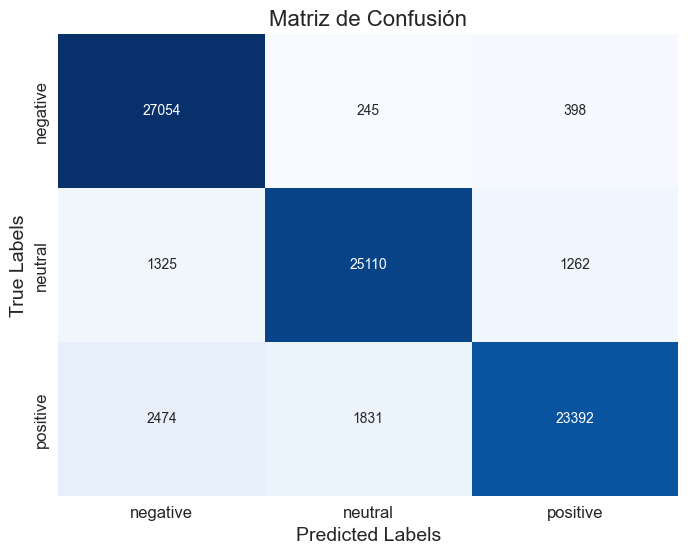

In [50]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de clasificacion

In [47]:
print(classification_report(y_over, predicted))

              precision    recall  f1-score   support

    negative       0.88      0.98      0.92     27697
     neutral       0.92      0.91      0.92     27697
    positive       0.93      0.84      0.89     27697

    accuracy                           0.91     83091
   macro avg       0.91      0.91      0.91     83091
weighted avg       0.91      0.91      0.91     83091



#### Datos con SubMuestreo

In [52]:
# Crear instancia del modelo
model = DecisionTreeClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_under, y_under, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud de cada fold: [0.76260107 0.75847239 0.76604163 0.7725787  0.76376462]
Exactitud promedio: 0.7646916829390991


Accuracy Train

In [53]:
predicted = cross_val_predict(model, X_under, y_under, cv=5)

In [55]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_under, predicted)))

Model accuracy score with criterion gini index: 0.7645


Matriz de Confusion

In [57]:
cm = confusion_matrix(y_under, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[6756 1233 1699]
 [ 957 8321  410]
 [1719  827 7142]]


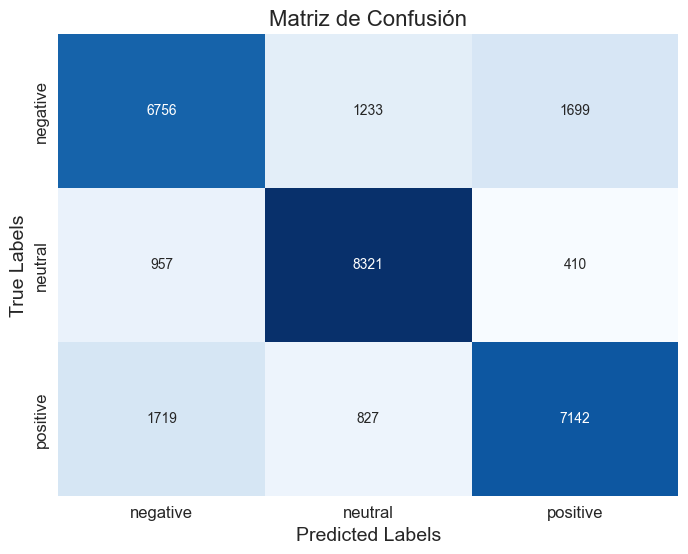

In [58]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de Clasificacion

In [59]:
print(classification_report(y_under, predicted))

              precision    recall  f1-score   support

    negative       0.72      0.70      0.71      9688
     neutral       0.80      0.86      0.83      9688
    positive       0.77      0.74      0.75      9688

    accuracy                           0.76     29064
   macro avg       0.76      0.76      0.76     29064
weighted avg       0.76      0.76      0.76     29064



### RandomForestClassifier

#### Datos Normales

In [61]:
# Crear instancia del modelo
model = RandomForestClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_train, y_train, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud de cada fold: [0.8550168  0.86205793 0.85365659 0.86044651 0.86052653]
Exactitud promedio: 0.8583408701077536


In [63]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [64]:
y_pred = model.predict(X_test)

Check de accuracy

In [65]:
print('Model accuracy score with doors variable removed : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with doors variable removed : 0.8605


Matriz de Confusion

In [66]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1093  405  955]
 [   5 6475  356]
 [  70  389 5874]]


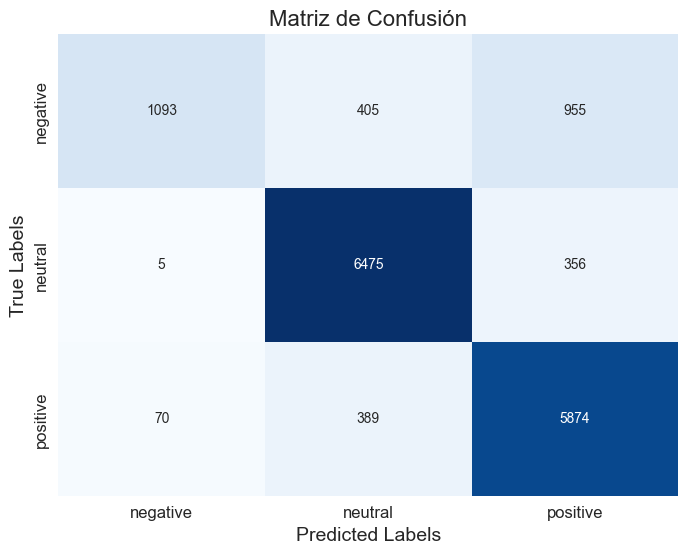

In [67]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de Clasificacion

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.94      0.45      0.60      2453
     neutral       0.89      0.95      0.92      6836
    positive       0.82      0.93      0.87      6333

    accuracy                           0.86     15622
   macro avg       0.88      0.77      0.80     15622
weighted avg       0.87      0.86      0.85     15622



#### Datos con sobremuestreo

In [69]:
# Crear instancia del modelo
model = RandomForestClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_over, y_over, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))


Exactitud de cada fold: [0.92983934 0.93164039 0.95191961 0.95306294 0.96190877]
Exactitud promedio: 0.9456742106229328


In [71]:
predicted = cross_val_predict(model, X_over, y_over, cv=5)

Check the accuracy

In [72]:
print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_over, predicted)))

Model accuracy score with criterion gini index: 0.9453


Matriz de Confusion

In [73]:
cm = confusion_matrix(y_over, predicted)

print('Confusion matrix\n\n', cm)


Confusion matrix

 [[26948   217   532]
 [  240 26031  1426]
 [  622  1504 25571]]


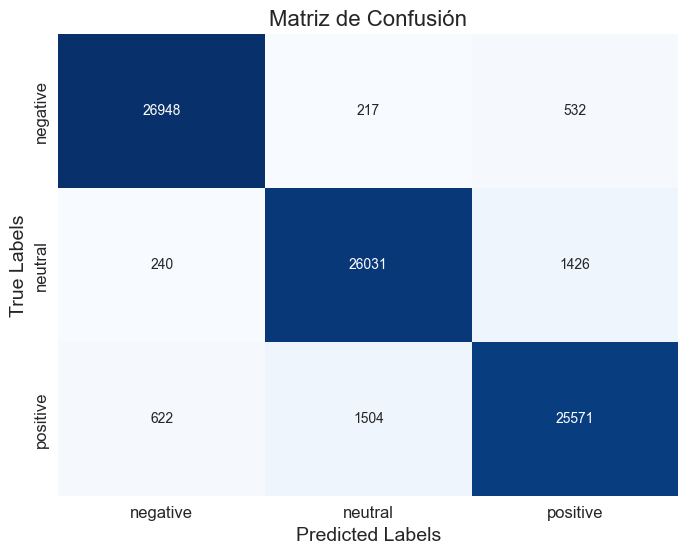

In [74]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()


Reporte de Clasificacion

In [75]:
print(classification_report(y_over, predicted))

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97     27697
     neutral       0.94      0.94      0.94     27697
    positive       0.93      0.92      0.93     27697

    accuracy                           0.95     83091
   macro avg       0.95      0.95      0.95     83091
weighted avg       0.95      0.95      0.95     83091



#### Datos con Submuestreo

In [76]:
# Crear instancia del modelo
model = RandomForestClassifier()

# Realizar validación cruzada
scores = cross_val_score(model, X_under, y_under, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))


Exactitud de cada fold: [0.82711165 0.83364872 0.82212283 0.82539136 0.81693049]
Exactitud promedio: 0.8250410091343074


In [77]:
predicted = cross_val_predict(model, X_under, y_under, cv=5)

Check de accuracy

In [78]:
print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_under, predicted)))

Model accuracy score with criterion gini index: 0.8235


Matriz de Confusion

In [79]:
cm = confusion_matrix(y_under, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[7382  870 1436]
 [ 805 8599  284]
 [1080  656 7952]]


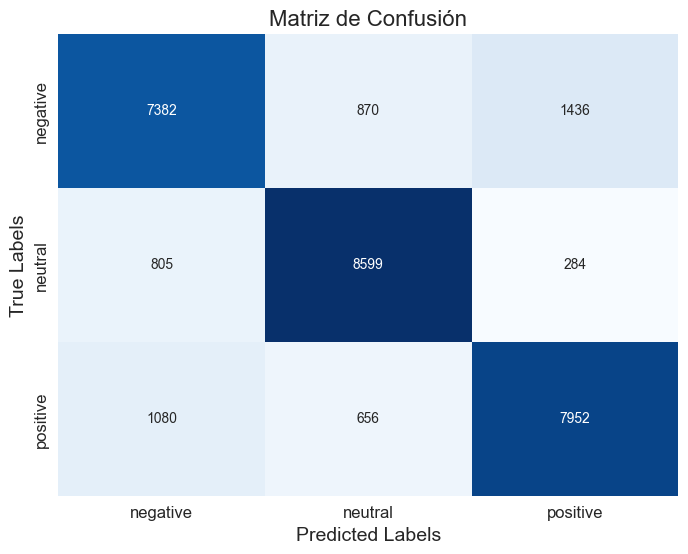

In [80]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels =['negative', 'neutral','positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()


Reporte de Clasificacion

In [81]:
print(classification_report(y_under, predicted))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78      9688
     neutral       0.85      0.89      0.87      9688
    positive       0.82      0.82      0.82      9688

    accuracy                           0.82     29064
   macro avg       0.82      0.82      0.82     29064
weighted avg       0.82      0.82      0.82     29064



### SVM

In [16]:
# Crear instancia del modelo
model = SVC()

# Realizar validación cruzada
scores = cross_val_score(model, X_train, y_train, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))


Exactitud de cada fold: [0.92054729 0.92486798 0.92238758 0.92150116 0.91870049]
Exactitud promedio: 0.9216008993702735


In [17]:
model.fit(X_train, y_train)

SVC()

In [18]:
y_pred = model.predict(X_test)

Check the accuracy

In [19]:
print('Model accuracy score with doors variable removed : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with doors variable removed : 0.9263


Matriz de Confusion

In [20]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1766  230  457]
 [   6 6811   19]
 [ 175  265 5893]]


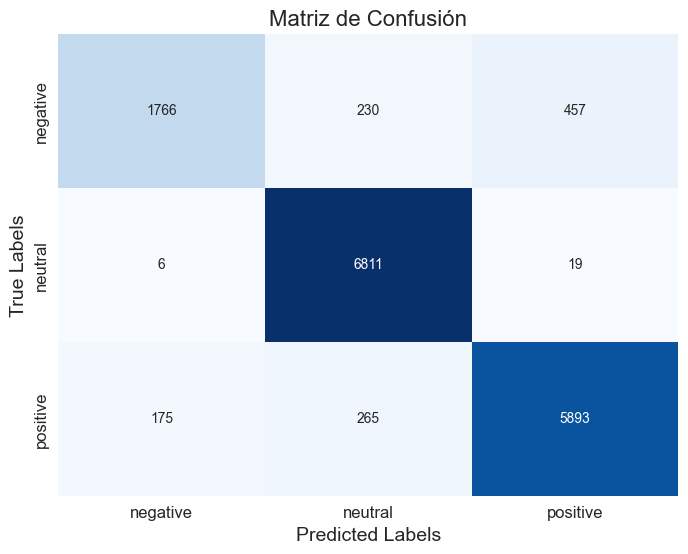

In [21]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels = ['negative', 'neutral', 'positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de Clasificacion

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.72      0.80      2453
     neutral       0.93      1.00      0.96      6836
    positive       0.93      0.93      0.93      6333

    accuracy                           0.93     15622
   macro avg       0.92      0.88      0.90     15622
weighted avg       0.93      0.93      0.92     15622



#### Datos con sobremuestreo

In [23]:
# Crear instancia del modelo
model = SVC()

# Realizar validación cruzada
scores = cross_val_score(model, X_over, y_over, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud de cada fold: [0.9570973  0.95757612 0.9687688  0.96702371 0.97580936]
Exactitud promedio: 0.9652550596064715


In [24]:
predicted = cross_val_predict(model, X_over, y_over, cv=5)

Check the accuracy

In [25]:
print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_over, predicted)))

Model accuracy score with criterion gini index: 0.9653


Matriz de Confusion

In [26]:
cm = confusion_matrix(y_over, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[27020   196   481]
 [   87 27524    86]
 [ 1112   925 25660]]


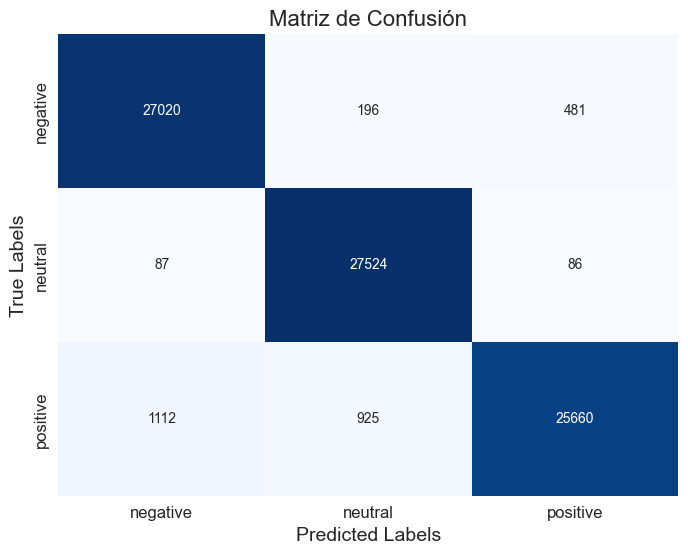

In [27]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels = ['negative', 'neutral', 'positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de clasificacion

In [29]:
print(classification_report(y_over, predicted))

              precision    recall  f1-score   support

    negative       0.96      0.98      0.97     27697
     neutral       0.96      0.99      0.98     27697
    positive       0.98      0.93      0.95     27697

    accuracy                           0.97     83091
   macro avg       0.97      0.97      0.97     83091
weighted avg       0.97      0.97      0.97     83091



#### Datos con Submuestreo

In [30]:
# Crear instancia del modelo
model = SVC()

# Realizar validación cruzada
scores = cross_val_score(model, X_under, y_under, cv=5)

# Imprimir los resultados de la validación cruzada
print("Exactitud de cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))


Exactitud de cada fold: [0.88284879 0.88147256 0.8835369  0.88611732 0.87422574]
Exactitud promedio: 0.8816402623684791


In [31]:
predicted = cross_val_predict(model, X_under, y_under, cv=5)


Check the accuracy

In [32]:
print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_under, predicted)))

Model accuracy score with criterion gini index: 0.8816


Matriz de Confusion

In [33]:
cm = confusion_matrix(y_under, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[8088  750  850]
 [ 249 9389   50]
 [ 918  623 8147]]


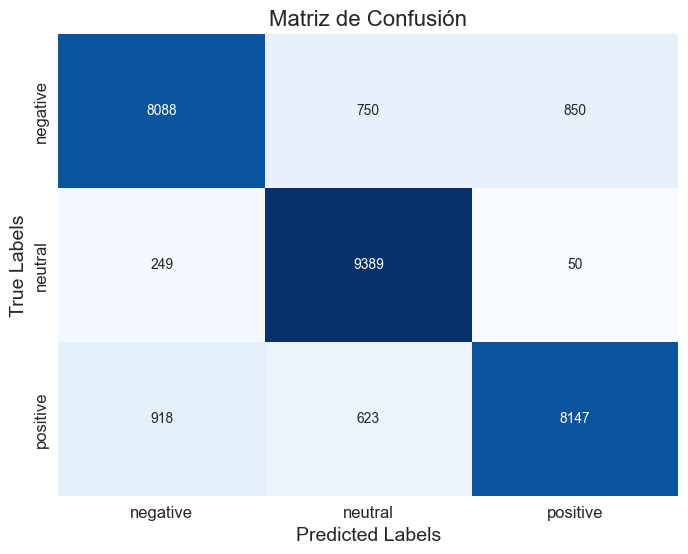

In [34]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

labels = ['negative', 'neutral', 'positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

# Configurar etiquetas
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Reporte de clasificacion

In [36]:
print(classification_report(y_under, predicted))

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      9688
     neutral       0.87      0.97      0.92      9688
    positive       0.90      0.84      0.87      9688

    accuracy                           0.88     29064
   macro avg       0.88      0.88      0.88     29064
weighted avg       0.88      0.88      0.88     29064



## Conclusiones y Recomendaciones

### Conclusiones
1. El modelo SVM es el más consistente y preciso en todos los escenarios, demostrando ser la mejor opción para este conjunto de datos.

2. El sobremuestreo mejora el desempeño de los modelos significativamente, siendo una estrategia clave para abordar desequilibrios en los datos.

3. El submuestreo, aunque mejora algunos resultados, no es tan efectivo como el sobremuestreo.

### Recomendaciones
 1. Dado que el sobremuestreo mostró un impacto positivo en los modelos de machine learning, considera aplicarlo en futuros análisis de sentimientos, especialmente si identificas un desbalance significativo entre las opiniones positivas, negativas y neutrales. Esto garantizará que el modelo capture mejor las características de las clases minoritarias.

2. El modelo SVM ha demostrado ser consistente y eficaz en tus resultados. Por ello, es recomendable priorizarlo en futuros análisis de este tipo, especialmente cuando trabajes con conjuntos de datos similares, ya que puede capturar patrones más complejos relacionados con el tono y las emociones en los comentarios.

3. Para enriquecer futuros análisis de sentimientos, incluye más variables como el tiempo de visualización del video, las palabras clave en los comentarios, o el tipo de reacción de los usuarios (me gusta, dislikes, etc.). Estas variables pueden ayudarte a tener una visión más completa de la percepción del público sobre el lanzamiento.
